In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import seaborn as sns
# import cobra
import scipy.stats as st
import scipy
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import reframed

## Note run in condas env pandas2

In [57]:

folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-UniversitédeLausanne/UNIL/leakage/experimental work/sintef_sept_23/exometabolome')

In [58]:
fn = folder / 'SM_Quantitative_Results.xlsx'
mapping_fn = folder / 'met_to_bigg.csv'
od_fn = folder / '..' / 'REL-F-U37-23_OD_TV.xlsx'

## Read mapping

In [59]:
mapping_dict = pd.read_csv(mapping_fn, index_col = 0).to_dict()['BiGG ID']

## Read OD and convert to biomass

In [60]:
od_df = pd.read_excel(od_fn, skiprows=2, nrows=21)
od_df.drop(index = 0, inplace=True)

In [61]:
rel_to_info = {
    'REL01': {'M': 'M1', 'CS': 'Galactose'},
    'REL02': {'M': 'M2', 'CS': 'Galactose'},
    'REL03': {'M': 'M3', 'CS': 'Galactose'},
    'REL04': {'M': 'M5', 'CS': 'L-malate'},
    'REL05': {'M': 'M6', 'CS': 'L-malate'},
    'REL06': {'M': 'M7', 'CS': 'L-malate'},
    'REL07': {'M': 'M9', 'CS': 'L-alanine'},
    'REL08': {'M': 'M10', 'CS': 'L-alanine'},
    'REL09': {'M': 'M11', 'CS': 'L-alanine'}
    }
M_to_rel = {dic['M']:rel for rel, dic in rel_to_info.items()}


In [62]:
od_df.rename(columns={'Unnamed: 0': 'Timestamp', 'Unnamed: 1': 'Time', 'Unnamed: 2': 'Hours'}, inplace=True)

In [63]:
gDW_per_OD = {
    'Galactose': 0.35, # gDW/L,
    'L-malate':  0.28,
    'L-alanine': 0.3
}

In [64]:
gdw_df = pd.DataFrame()
gdw_df['Hours'] = od_df['Hours']

In [65]:
for rel, dic in rel_to_info.items():
    gdw_df[rel] = od_df[rel]*gDW_per_OD[dic['CS']]

## Read exometabolome

In [72]:
df = pd.read_excel(fn, nrows=46)

In [73]:
df.columns = [x.rstrip(' ') for x in df.columns]

In [74]:
df.drop(index = 0, inplace=True)

In [75]:
data_columns = ['PHENYLALANINE', 'LEUCINE',
       'ISOLEUCINE', 'METHIONINE', 'GAMMA-AMINOBUTYRATE', 'PROLINE',
       'TYROSINE', 'VALINE', 'PIPECOLIC ACID', 'ALPHA-AMINOBUTYRATE',
       'BETA-ALANINE', 'ALANINE', 'CREATINE', 'ALPHA-AMINOADIPATE',
       'GLYCINE', 'GLUTAMINE', 'GLUTAMATE', 'SERINE', 'ASPARAGINE',
       'ASPARTATE', 'LYSINE', 'PYRUVATE', 'LACTATE',
       'HEXOSES including Glucose and Fructose', 'NAD', 'GLUTARATE',
       'SUCCINATE', 'MALATE', 'CIS-ACONITATE', 'CITRATE', 'ISOCITRATE',
       'TRANS-ACONITATE']
control_samples = ['\xa0 M9 Alanine_001', 'M9 Alanine_002', '\xa0\xa0 M9 Alanine_003',
       ' M9 Galactose_001', ' M9 Galactose_002', ' M9 Galactose_003',
       'M9 malate_001', 'M9 malate_002', 'M9 malate_003']

In [76]:
control_idx = df['USER CODE'].isin(control_samples)

In [77]:
df.rename(columns = {'Class 1':'Carbon source', 'Class 2':'Timepoint-tag'}, inplace=True)

# Drop columns that are not interesting (doesn't map to model)

In [78]:
df.drop(columns = ['SEBACOYL-L-CARNITINE (C10-DC)', 'DEOXYCARNITINE (DEOXY-C0)',
       'GLUTARYLCARNITINE (C5-DC)'], inplace=True)

## Outliers in medium measurements

We have double checked Malate and indeed, the higher values of Malate observed in the highlighted samples is due to a carry-over from the fresh media Malate. All samples were blinded randomized for the analysis and SM_MPTA_112023_39_Galactose-T8_M3_3; SM_MPTA_112023_ FreshMedia_M9 Alanine_003_39 and also SM_MPTA_112023_88_L-alanine-T18_M9_31 were injected just after the A M9_malate sample. What explains the 10-fold difference observed.
 
We have a LC-MS and autosampler wash step before and after each injection in order to minimize / reduce the carry-over but in this case the concentration of Malate in the Malate-fresh media was to high in comparison to the other values.


In [79]:
df.loc[39, ['SUCCINATE', 'MALATE']] = np.nan
# df['MALATE'] = 'ND'
# Also errors with malate
# Galactose-T12_M1_4, Galactose-T8_M3, Galactose-T14_M2, Galactose-T14_M3, Galactose-T6_M2, Galactose-T12_M2, L-alanine-T18_M11, L-alanine-T18_M9

# FOr hexose
# L-alanine-T18_M11

In [81]:
df.tail()

,Sample_ID,USER CODE,Carbon source,Timepoint-tag,PHENYLALANINE,LEUCINE,ISOLEUCINE,METHIONINE,GAMMA-AMINOBUTYRATE,PROLINE,...,LACTATE,HEXOSES including Glucose and Fructose,NAD,GLUTARATE,SUCCINATE,MALATE,CIS-ACONITATE,CITRATE,ISOCITRATE,TRANS-ACONITATE
41,SM_MPTA_112023_ FreshMedia_M9 Galactose_002_41,M9 Galactose_002,Galactose,T0,0.007935,ND,ND,ND,0.028205,0.027638,...,4.28256,37352.790874,ND,ND,ND,0.131436,ND,ND,ND,ND
42,SM_MPTA_112023_ FreshMedia_M9 Galactose_003_42,M9 Galactose_003,Galactose,T0,0.001259,ND,ND,ND,ND,0.015408,...,1.50591,40693.20641,ND,ND,ND,2.256583,ND,ND,ND,ND
43,SM_MPTA_112023_ FreshMedia_M9 malate_001_43,M9 malate_001,L-malate,T0,0.051862,ND,ND,ND,ND,0.071103,...,18.173573,ND,ND,4.731919,967.347454,26034.910584,ND,ND,ND,ND
44,SM_MPTA_112023_ FreshMedia_M9 malate_002_44,M9 malate_002,L-malate,T0,0.049358,ND,0.063293,ND,ND,0.021933,...,9.968043,ND,ND,3.847096,625.067213,26893.54499,ND,ND,ND,ND
45,SM_MPTA_112023_ FreshMedia_M9 malate_003_45,M9 malate_003,L-malate,T0,0.040061,ND,0.039175,ND,ND,ND,...,11.473287,ND,ND,3.510805,648.210703,29258.014474,ND,ND,ND,ND


# Make long table


In [82]:
dfl = df.loc[:,:].melt(id_vars=['Sample_ID', 'USER CODE', 'Carbon source', 'Timepoint-tag'], value_vars=data_columns, value_name='Concentration', var_name = 'Metabolite')

In [83]:
dfl['Hours'] = [int(x[1].split('-T')[-1]) if 'T' in x[1] else 0 for x in dfl['USER CODE'].str.split(' ') ]


In [84]:
dfl

,Sample_ID,USER CODE,Carbon source,Timepoint-tag,Metabolite,Concentration,Hours
0,SM_MPTA_112023_28_Galactose-T6_M1_1,#28: Galactose-T6 M1,Galactose,T1,PHENYLALANINE,0.002685,6
1,SM_MPTA_112023_29_Galactose-T6_M2_2,#29: Galactose-T6 M2,Galactose,T1,PHENYLALANINE,ND,6
2,SM_MPTA_112023_39_Galactose-T8_M3_3,#39: Galactose-T8 M3,Galactose,T1,PHENYLALANINE,ND,8
3,SM_MPTA_112023_55_Galactose-T12_M1_4,#55: Galactose-T12 M1,Galactose,T2,PHENYLALANINE,0.014445,12
4,SM_MPTA_112023_56_Galactose-T12_M2_5,#56: Galactose-T12 M2,Galactose,T2,PHENYLALANINE,0.026071,12
...,...,...,...,...,...,...,...
1435,SM_MPTA_112023_ FreshMedia_M9 Galactose_002_41,M9 Galactose_002,Galactose,T0,TRANS-ACONITATE,ND,0
1436,SM_MPTA_112023_ FreshMedia_M9 Galactose_003_42,M9 Galactose_003,Galactose,T0,TRANS-ACONITATE,ND,0
1437,SM_MPTA_112023_ FreshMedia_M9 malate_001_43,M9 malate_001,L-malate,T0,TRANS-ACONITATE,ND,0
1438,SM_MPTA_112023_ FreshMedia_M9 malate_002_44,M9 malate_002,L-malate,T0,TRANS-ACONITATE,ND,0


In [85]:
dfl.replace('ND', np.nan, inplace=True)

In [86]:
control_idx_l = dfl.Hours == 0

In [87]:
dfl['Timepoint'] = dfl['Timepoint-tag'].str.strip('T').astype(int)


dfl['M'] = [x[-1] for x in dfl['USER CODE'].str.split(' ')]

## Export data


In [88]:
gdw_df.to_csv('gDW.csv')
dfl.to_csv('long_table.csv')

## Read medium values

In [24]:
control_df = df.loc[control_idx,:].copy()
# control_df.fillna(0, inplace = True)
control_df.replace('ND', np.nan, inplace=True)
medium_dict = control_df.groupby(by = 'Carbon source').mean(data_columns).to_dict(orient = 'index')


In [25]:
control_df = control_df[['Carbon source']+data_columns]

# Plot data

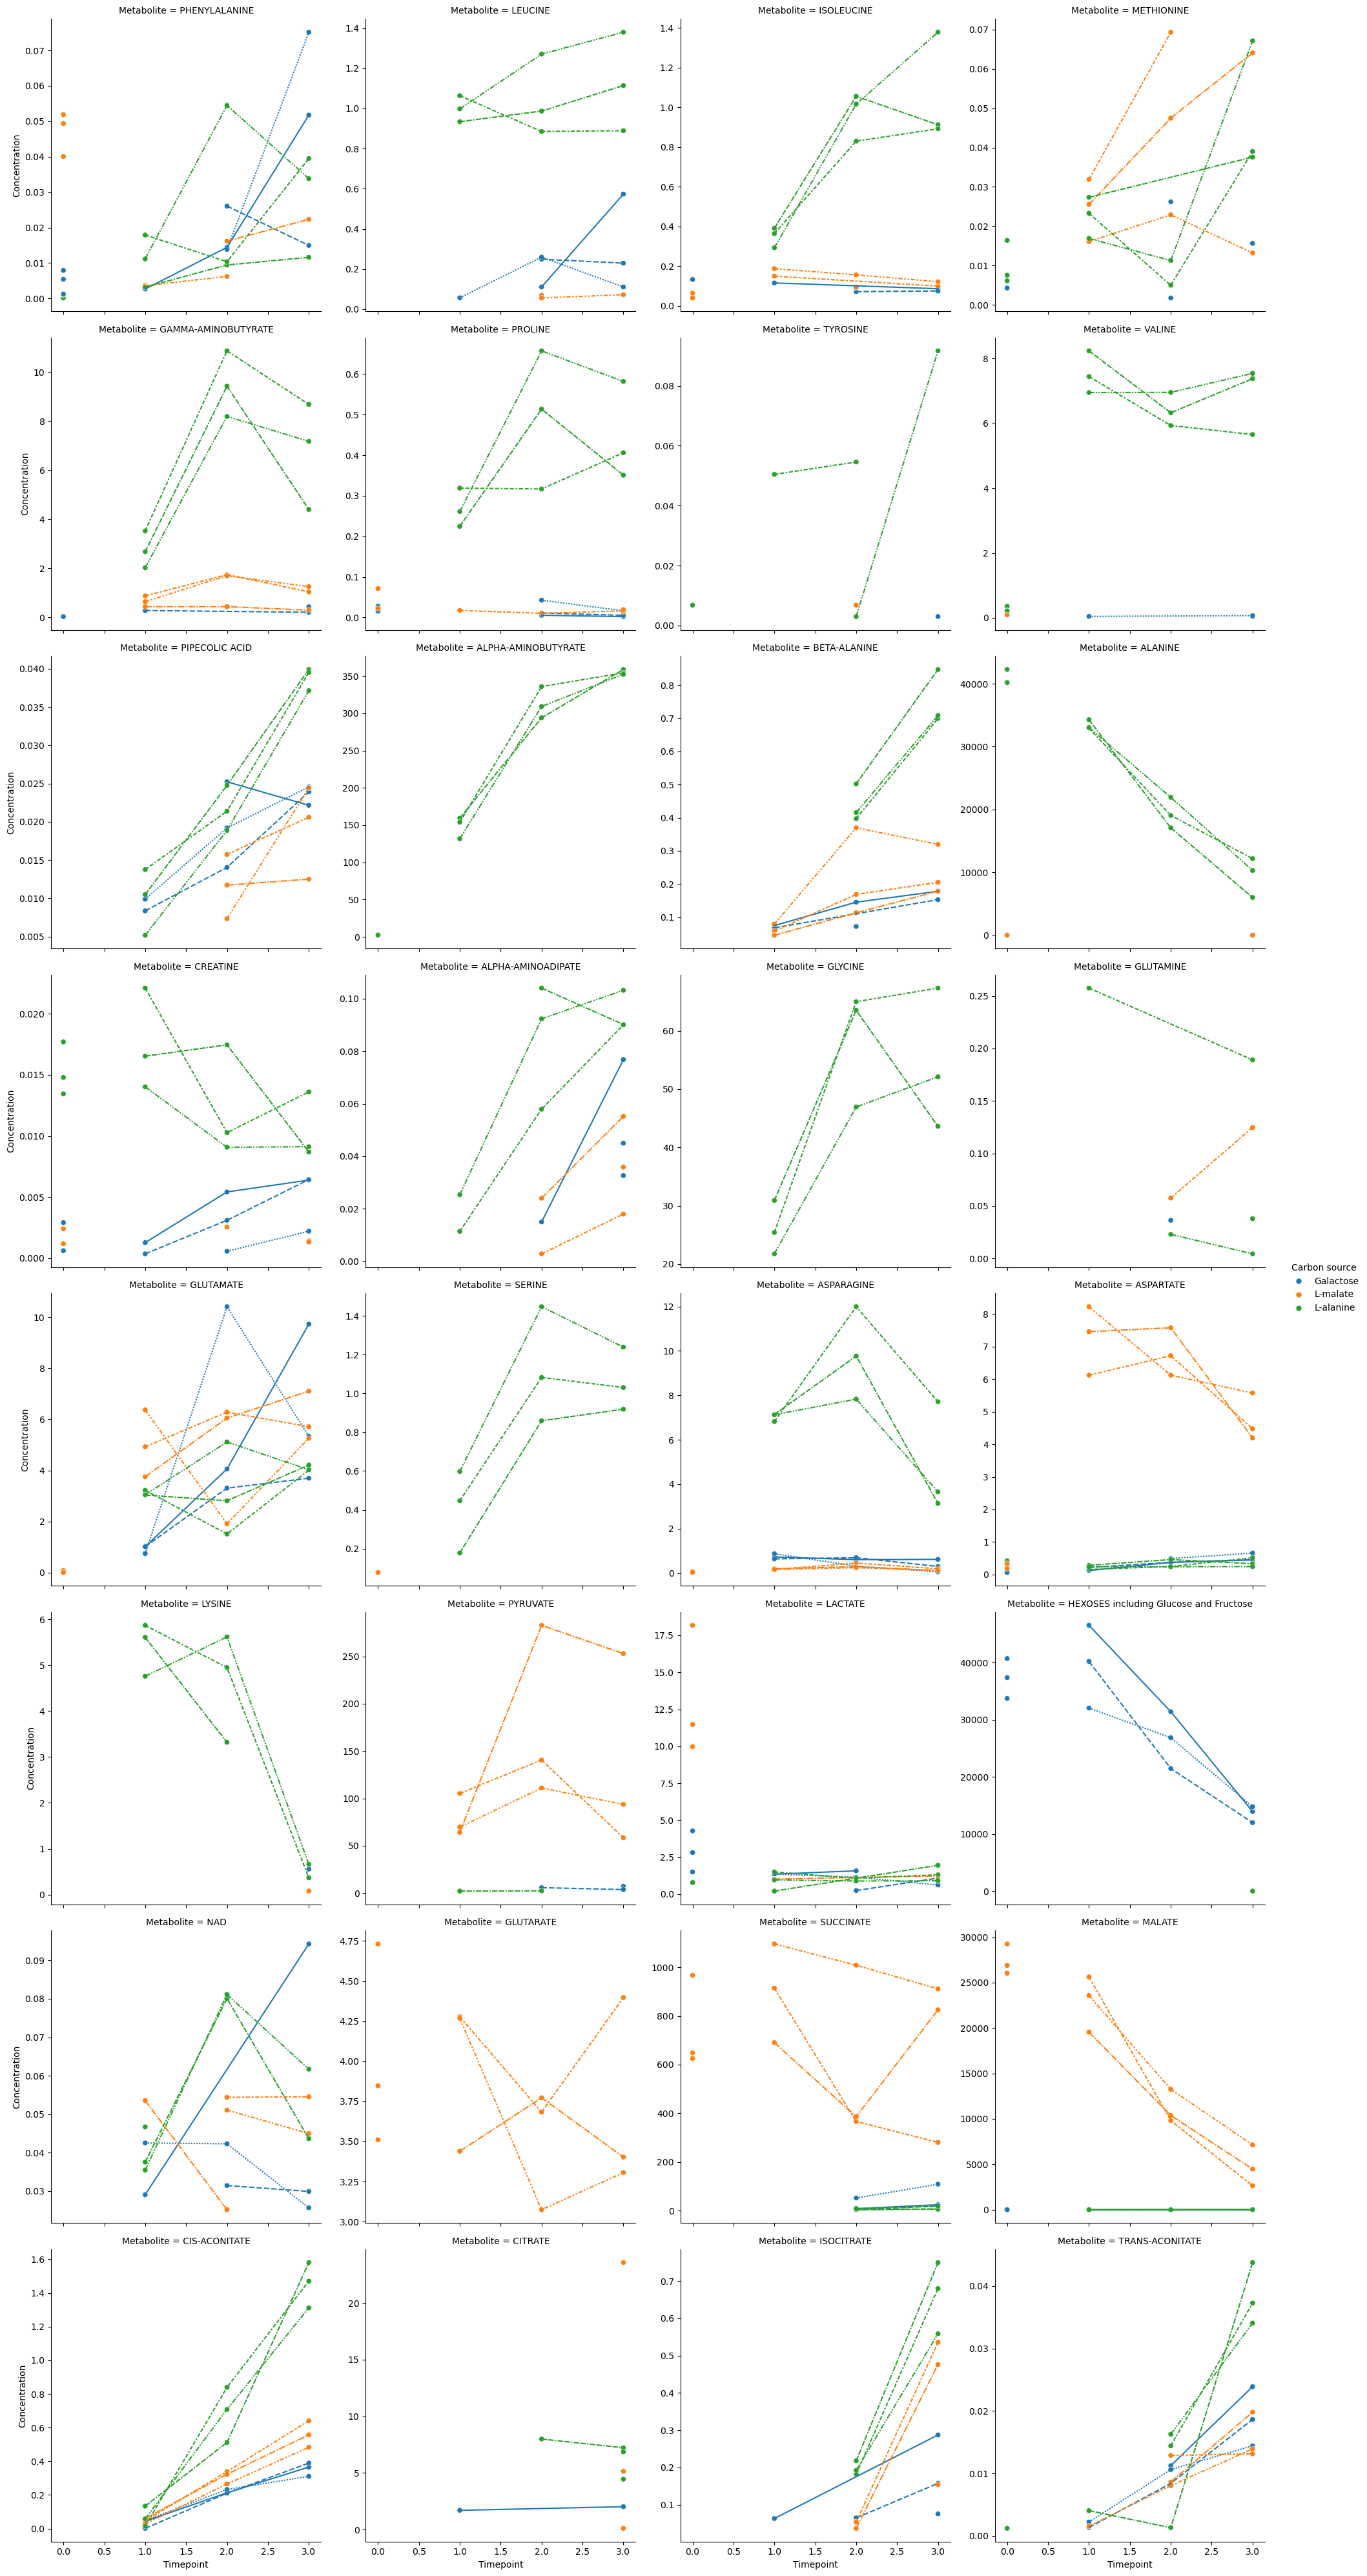

In [26]:
ax = sns.relplot(data = dfl.loc[dfl.Timepoint != 4,:], x = 'Timepoint', y = 'Concentration', hue = 'Carbon source', col = 'Metabolite', col_wrap=4, facet_kws={'sharey': False})
ax.map_dataframe(sns.lineplot, 'Timepoint', 'Concentration', hue = 'Carbon source', style = 'M')
plt.show()

# Estimate rate per bioreactor


In [87]:
data = []
plot = False
data_rate = []

for m in dfl.M.unique():
    # if not m in ['M5', 'M6', 'M7']:
    #     continue
    for met in dfl.Metabolite.unique():
        # print(met, m)
        idx = (dfl.M == m) & (dfl.Metabolite == met) & (dfl.Timepoint != 4) & ~control_idx_l
        dfi = dfl.loc[idx,['Concentration', 'Hours', 'Carbon source', 'Timepoint']].copy()
        dfi.sort_values('Hours', inplace=True)
        # print(m, met)
        # print(dfi)
        dfi.dropna(axis = 0, inplace=True)
    
        if not len(dfi):
            continue
        cs = dfi['Carbon source'].values[0]  
        # if len(dfi) == 1:
        # Add medium concentrations
        medium_values = control_df.loc[control_df['Carbon source']==cs, met].values
        if np.isfinite(medium_values).sum() == 0:
            dfi.loc[-1,:] = [0, 0, cs, 0]
        else:
            dfi.loc[-1,:] = [np.nanmean(medium_values), 0, cs, 0]
        if (2 in dfi.Timepoint.values) and (3 in dfi.Timepoint.values):
            t3_value = dfi.loc[dfi.Timepoint == 3, 'Concentration'].values[0]
            t2_value = dfi.loc[dfi.Timepoint == 2, 'Concentration'].values[0]
            if  t3_value < t2_value:
                # Indicates that the matbolite is being reconsumed, discard last point from estimating rates
                # And compensate by adding time 0
                dfi = dfi.loc[dfi.Timepoint != 3, :]
                # dfi.loc[-1,:] = [medium_dict[cs][met], 0, cs, 0]

        # If medium values are larger than values at t1
        if len(dfi.loc[dfi.Timepoint > 0, :]) > 1:
            
            non_medium_conc = dfi.loc[dfi.Timepoint > 0,'Concentration'].values
            if (dfi.loc[-1, 'Concentration'] > non_medium_conc[0]) and (non_medium_conc[0] < non_medium_conc[1]):
                dfi.drop(index = [-1], inplace = True)
                print('Drop 0', m, met, cs)
                # The maximum value 
        # print(dfi)
        time_conc_dict = {key: (value['Hours'], value['Concentration']) for key, value in dfi[['Hours', 'Concentration']].to_dict(orient = 'index').items()}
        max_time = max(list(time_conc_dict.keys()))
        rel = M_to_rel[m]
        gdw = gdw_df[['Hours', rel]].copy()
        gdw.dropna(inplace=True)
        m_data = []
        for index, val_tuple in time_conc_dict.items():
            time, conc = val_tuple
            # Calculate cumulative OD
            tidx = gdw.Hours < time+0.5
            conc_mM = conc * 1e-3
            cum_dw = scipy.integrate.simpson(gdw.loc[tidx, rel], gdw.loc[tidx, 'Hours'])
            data.append([m, met, time, conc_mM, cum_dw, cs])
            m_data.append([conc_mM, cum_dw])

        m_df = pd.DataFrame(m_data, columns = ['Concentration [mM]', 'Integral of biomass [gDW*h/L]'])
        popt, pcov = scipy.optimize.curve_fit(lambda x,a,b: a*x+b, m_df['Integral of biomass [gDW*h/L]'], 
                                              m_df['Concentration [mM]'])
        rate = popt[0]
        data_rate.append([m, met, cs, rate, pcov[0,0]])
        if plot:
            print(m, met)
            plt.scatter(m_df['Integral of biomass [gDW*h/L]'], m_df['Concentration [mM]'])
            x = np.linspace(0,max_time, 4)
            plt.plot(x, rate*x + popt[1])
            plt.show()
df_conc_biomass = pd.DataFrame(data, columns = ['M', 'Metabolite', 'Time', 'Concentration [mM]', 'Integral of biomass [gDW*h/L]', 'Carbon source'])
df_rate = pd.DataFrame(data_rate, columns = ['M', 'Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]', 'Rate var'])

Drop 0 M1 PHENYLALANINE Galactose
Drop 0 M1 CREATINE Galactose
Drop 0 M1 LACTATE Galactose
Drop 0 M1 MALATE Galactose
Drop 0 M2 ISOLEUCINE Galactose
Drop 0 M2 CREATINE Galactose
Drop 0 M2 LACTATE Galactose


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda

Drop 0 M3 CREATINE Galactose
Drop 0 M6 PHENYLALANINE L-malate
Drop 0 M6 LACTATE L-malate
Drop 0 M6 GLUTARATE L-malate
Drop 0 M7 PHENYLALANINE L-malate


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda

Drop 0 M9 ASPARTATE L-alanine
Drop 0 M9 LACTATE L-alanine
Drop 0 M9 MALATE L-alanine
Drop 0 M10 ASPARTATE L-alanine
Drop 0 M11 TYROSINE L-alanine


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


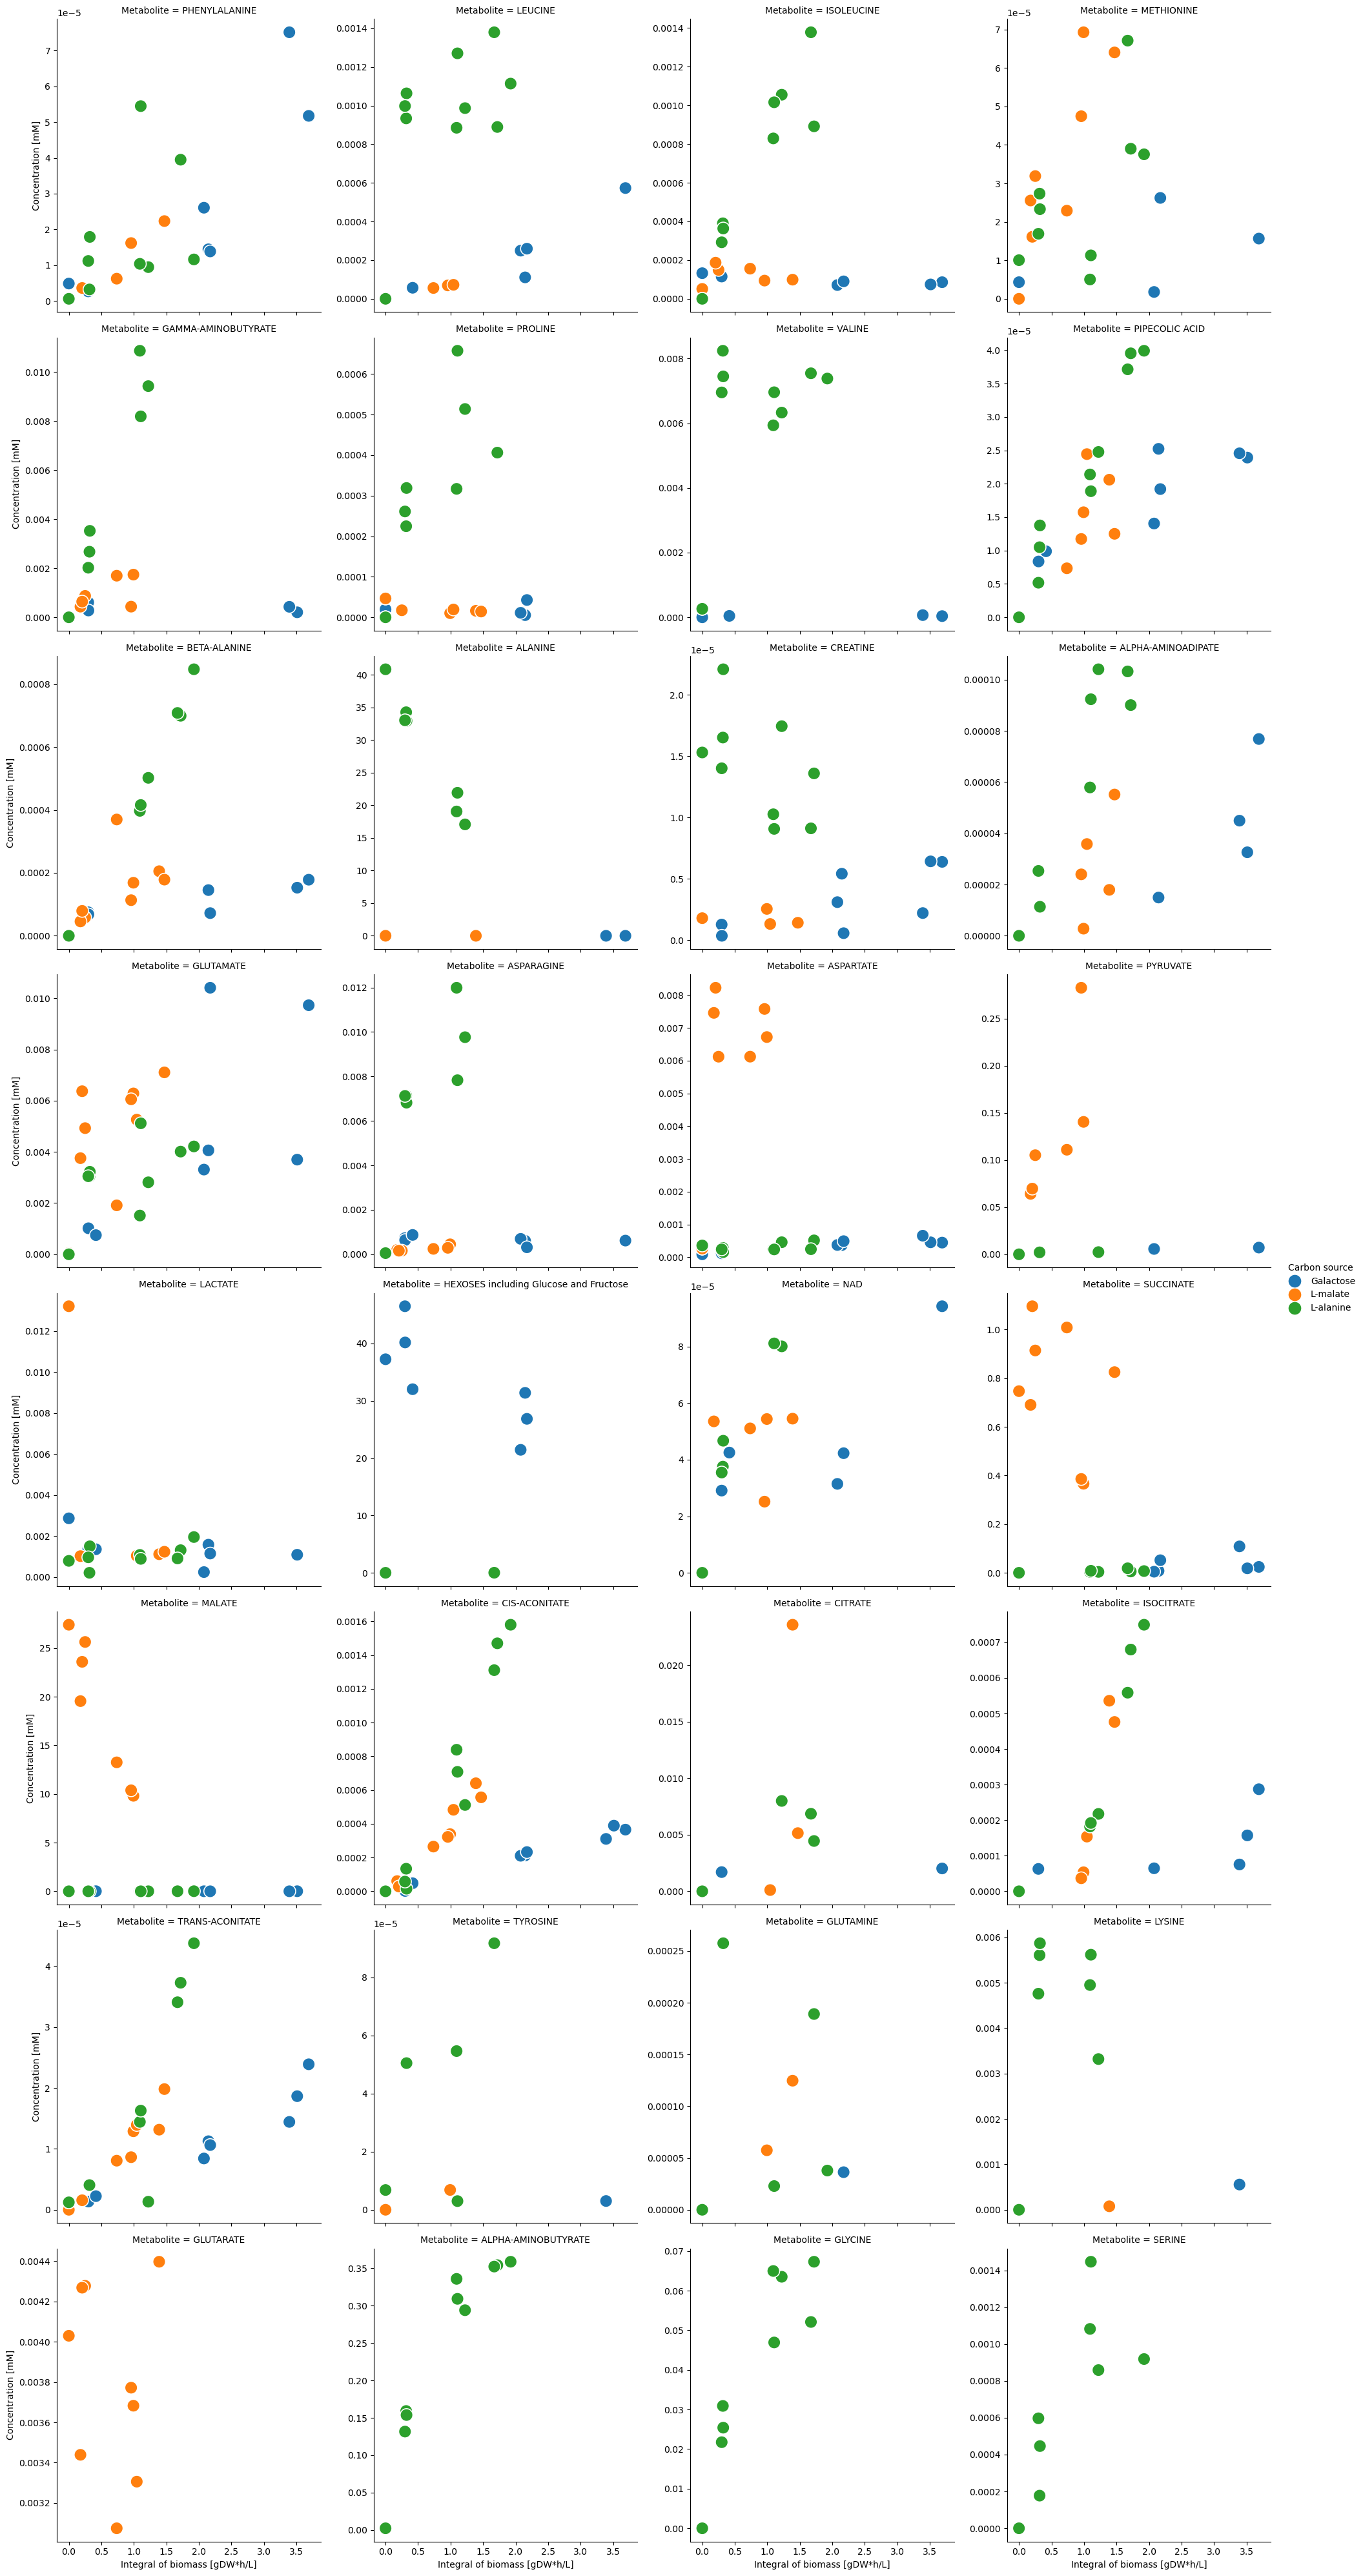

In [84]:
sns.relplot(data = df_conc_biomass, x = 'Integral of biomass [gDW*h/L]', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, facet_kws={'sharey': False}, hue = 'Carbon source', s = 200)
plt.show()

## Uptake rates

In [88]:
df_rate.loc[(df_rate['Metabolite'] == 'MALATE')&(df_rate['Carbon source'] == 'L-malate'),'Rate [mmol/gDW/h]'].mean()

-17.907915989227387

In [91]:
df_rate.loc[(df_rate['Metabolite'] == 'ALANINE')&(df_rate['Carbon source'] == 'L-alanine'),'Rate [mmol/gDW/h]'].mean()

-18.455545069083623

In [92]:
df_rate.loc[(df_rate['Metabolite'] == 'HEXOSES including Glucose and Fructose')&(df_rate['Carbon source'] == 'Galactose'),'Rate [mmol/gDW/h]'].mean()

-5.837985832488621

In [93]:
ala = df_conc_biomass.loc[(df_conc_biomass['Metabolite'] == 'ALANINE')&(df_conc_biomass['Carbon source'] == 'L-alanine'),:]
np.polyfit(ala['Integral of biomass [gDW*h/L]'], ala['Concentration [mM]'], 1)

array([-18.50519986,  40.17663581])

In [94]:
gal = df_conc_biomass.loc[(df_conc_biomass['Metabolite'] == 'HEXOSES including Glucose and Fructose')&(df_conc_biomass['Carbon source'] == 'Galactose'),:]

In [95]:
np.polyfit(gal['Integral of biomass [gDW*h/L]'], gal['Concentration [mM]']/2, 1)

array([-2.9041662 , 19.62455341])

In [96]:
mal = df_conc_biomass.loc[(df_conc_biomass['Metabolite'] == 'MALATE')&(df_conc_biomass['Carbon source'] == 'L-malate'),:]

In [97]:
np.polyfit(mal['Integral of biomass [gDW*h/L]'], mal['Concentration [mM]'], 1)

array([-17.5771788 ,  26.97793079])

# Get models and estimate metabolite values

In [98]:
model_ez = reframed.load_cbmodel('../../models/e_coli/momentiJO1366.xml')
model_ez.solver = 'gurobi'

In [99]:
reframed.FBA(model_ez)

Objective: 0.7429753865197839
Status: Optimal

In [100]:
model_ez.reactions.R_EX_glc__D_e.lb = 0

In [101]:
cs_to_exchange = {
    'Galactose': 'R_EX_gal_e',
    'L-malate': 'R_EX_mal__L_e',
    'L-alanine': 'R_EX_ala__L_e'
}

In [102]:
measured_metabolite_ids = [f'M_{m_id}_c' for m_id in mapping_dict.values() if isinstance(m_id, str)]

In [103]:
uptake_rate = {
    'R_EX_gal_e': -5,
    'R_EX_mal__L_e': -17,
    'R_EX_ala__L_e': -18,
}
sp_dict = {}
for cs, ex_id in cs_to_exchange.items():
    sp_dict[cs] = leakage_reframed.estimate_shadow_prices(model_ez, constraints={ex_id:(uptake_rate[ex_id], 0)}, delta = 0.01, metabolites=measured_metabolite_ids)
        

In [104]:
mv_df = pd.DataFrame(sp_dict)*-1

In [105]:
mv_df

,Galactose,L-malate,L-alanine
M_cit_c,0.048685,0.013154,0.051376
M_fru_c,0.062348,0.055605,0.091846
M_icit_c,0.049484,0.014926,0.052369
M_lac__L_c,0.037397,0.026628,0.045078
M_glu__L_c,0.048972,0.015420,0.035399
M_mal__L_c,0.033004,0.008034,0.035278
M_nad_c,0.356770,0.380489,0.380662
M_succ_c,0.035520,0.008195,0.037844
M_acon_T_c,0.049084,0.014040,0.051873
M_asn__L_c,0.054211,0.046369,0.044251


# Turnover

In [106]:
turnover_dict = {}
for cs, ex_id in cs_to_exchange.items():
    solution = reframed.pFBA(model_ez, constraints={ex_id:(uptake_rate[ex_id], 0)})
    turnover = solution.get_metabolites_turnover(model_ez)
    turnover_dict[cs] = {m: turnover[m] for m in measured_metabolite_ids}
    print(cs)
    solution.show_values('BIO')
    # solution.show_values(ex_id)
    solution.show_values('R_EX')
    print("####")

Galactose
R_BIOMASS_Ec_iJO1366_core_53p95M  0.240429
R_EX_ca2_e   -0.00125143
R_EX_cl_e    -0.00125143
R_EX_co2_e    6.38109
R_EX_cobalt2_e -6.01073e-06
R_EX_cu2_e   -0.000170464
R_EX_fe2_e   -0.00386153
R_EX_gal_e   -2.70839
R_EX_h_e      2.20912
R_EX_h2o_e    12.7308
R_EX_k_e     -0.0469301
R_EX_meoh_e   4.80858e-07
R_EX_mg2_e   -0.00208572
R_EX_mn2_e   -0.000166136
R_EX_mobd_e  -3.10154e-05
R_EX_nh4_e   -2.59683
R_EX_ni2_e   -7.76586e-05
R_EX_o2_e    -5.86804
R_EX_pi_e    -0.231925
R_EX_so4_e   -0.0606386
R_EX_zn2_e   -8.19863e-05
####
L-malate
R_BIOMASS_Ec_iJO1366_core_53p95M  0.550032
R_EX_ac_e     0.320435
R_EX_ca2_e   -0.00286292
R_EX_cl_e    -0.00286292
R_EX_co2_e    38.8828
R_EX_cobalt2_e -1.37508e-05
R_EX_cu2_e   -0.000389973
R_EX_fe2_e   -0.00883406
R_EX_h_e     -25.6765
R_EX_h2o_e    37.8836
R_EX_k_e     -0.107362
R_EX_mal__L_e -15.5254
R_EX_meoh_e   1.10006e-06
R_EX_mg2_e   -0.00477153
R_EX_mn2_e   -0.000380072
R_EX_mobd_e  -7.09541e-05
R_EX_nh4_e   -5.9408
R_EX_ni2_e   -0

# Make table

In [112]:
data = []
Nc = []
mass = []
turnover_list = []
bigg_id_list = []
for _, row in df_rate.iterrows():
    cs = row['Carbon source']
    met = row['Metabolite']
    bigg_id = mapping_dict[met]
    if isinstance(bigg_id, str):
        m_id = f'M_{bigg_id}_c'
        data.append(-sp_dict[cs][m_id])
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc.append(element_dict['C'])
        mass.append(ng_utils.get_mol_weight(m))
        turnover_list.append(turnover_dict[cs][m_id])
        bigg_id_list.append(bigg_id)
        
    else:
        data.append(np.nan)
        Nc.append(np.nan)
        mass.append(np.nan)
        turnover_list.append(np.nan)
        bigg_id_list.append(np.nan)
        
df_rate['Metabolite value [gDW/mmol]'] = data
df_rate['N carbons'] = Nc
df_rate['Mol weight [g/mol]'] = mass
df_rate['Turnover [mmol/gDW/h]'] = turnover_list
df_rate['BiGG ID'] = bigg_id_list

In [115]:
df_rate['Species'] = "E. coli"
df_rate['Dataset'] = 'SINTEF-23'

In [116]:
df_rate.to_csv('sintef_2023_rates.csv')

In [114]:
df_rate

,M,Metabolite,Carbon source,Rate [mmol/gDW/h],Rate var,Metabolite value [gDW/mmol],N carbons,Mol weight [g/mol],Turnover [mmol/gDW/h],BiGG ID
0,M1,PHENYLALANINE,Galactose,0.000014,2.588807e-11,0.118664,9.0,165.18914,0.044543,phe__L
1,M1,LEUCINE,Galactose,0.000149,4.768345e-09,0.157820,6.0,131.17292,0.108321,leu__L
2,M1,ISOLEUCINE,Galactose,-0.000011,1.213977e-11,0.112259,6.0,131.17292,0.069852,ile__L
3,M1,METHIONINE,Galactose,0.000003,inf,0.221283,5.0,149.21134,0.037166,met__L
4,M1,GAMMA-AMINOBUTYRATE,Galactose,0.001951,inf,0.052451,4.0,103.11976,0.000000,4abut
...,...,...,...,...,...,...,...,...,...,...
227,M11,MALATE,L-alanine,0.003237,2.426341e-06,0.035278,4.0,132.07156,9.466151,mal__L
228,M11,CIS-ACONITATE,L-alanine,0.000801,8.031607e-09,NaN,NaN,NaN,NaN,NaN
229,M11,CITRATE,L-alanine,0.004103,inf,0.051376,6.0,189.09970,3.471456,cit
230,M11,ISOCITRATE,L-alanine,0.000312,1.403259e-08,0.052369,6.0,189.09970,3.471456,icit
